# Spherical droplet benchmark

To check in a realistic setting what errors in curvature (and, subsequently, anisotropic stress) we get through noisy image data, we run the stress analysis on droplets in force-free environments. For this, we evaluate a droplet embued in agarose. The data we use for this is provided [here](https://github.com/ElijahShelton/drop-recon/tree/master/tifs%20for%20test) under a [academic use license](https://github.com/ElijahShelton/drop-recon?tab=License-1-ov-file#readme).

According to the passed information, the metadata for this file are as follows:

```
filename: drop_in_agarose.tif
voxel size in x & y: 0.4151 um
voxel size in z: 1 um
```

In [1]:
import napari
import numpy as np
import requests
import scipy.ndimage as ndi
import vedo
from matplotlib import pyplot as plt
from napari.layers import Layer
from skimage import io

from napari_stress import (
    __version__,
    approximation,
    measurements,
    reconstruction,
)

In [2]:
print(f'napari-stress version: {__version__}')

napari-stress version: 0.3.9


In [3]:
viewer = napari.Viewer(ndisplay=3)

## Load the image

In [4]:
url = r'https://github.com/ElijahShelton/drop-recon/raw/refs/heads/master/tifs%20for%20test/drop_in_agarose.tif'
response = requests.get(url)

# Step 2: Save the file locally
with open('drop_in_agarose.tif', 'wb') as file:
    file.write(response.content)

# Step 3: Load the .tif file into a NumPy array
image_array = io.imread('drop_in_agarose.tif')

scale = np.asarray([1, 0.4151, 0.4151])

## Reconstruct droplet

In [5]:
reconstruction_results = reconstruction.reconstruct_droplet(
    image_array,
    voxelsize = scale,
    target_voxelsize = 0.4151,
    resampling_length = 1.0,
    edge_type = 'surface',
    trace_length = 20,
    use_dask=False
)

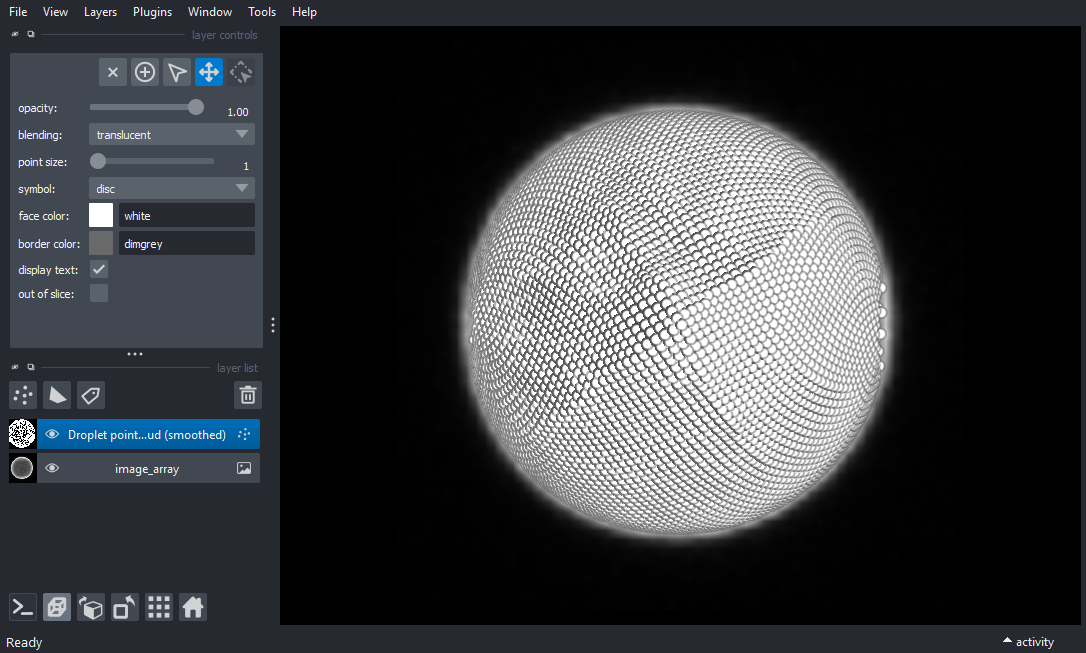

In [6]:
viewer.layers.clear()
viewer.add_image(image_array, scale=scale)
viewer.add_layer(Layer.create(*reconstruction_results[-1]))
napari.utils.nbscreenshot(viewer)

## Quantify errors: Radii

The first thing we'll look at is to compare the radii of all the points on the surface of the droplet. As a reference point for the center of the sphere, we will use the image's intensity-weighted center of mass. However, keep in mind that this is not super informative as it doesn't give us a relative error for the measurement.

In [7]:
points_reconstructed = reconstruction_results[-1][0]

In [20]:
# calculate the intensity weighted center of mass of the image
center_of_mass =  ndi.center_of_mass(image_array) * scale
radii = np.linalg.norm(points_reconstructed - center_of_mass, axis=1)
radius_mean = np.mean(radii)
radius_std = np.std(radii)

relative_error_radius = np.abs(radii - radius_mean) / radius_mean

Text(0.05, 0.95, 'Average rel. error: 0.012\nStd. dev. rel. error: 0.005')

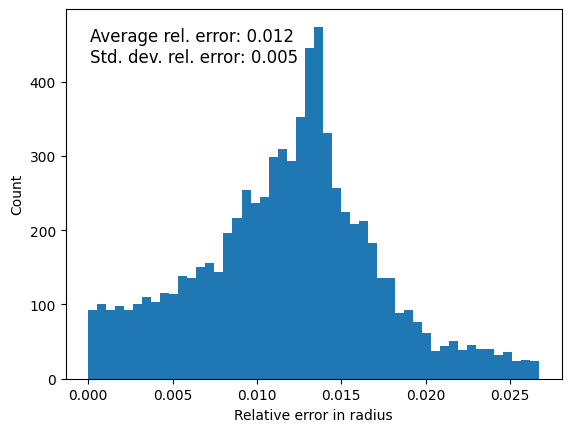

In [21]:

fig, ax = plt.subplots()
_ = ax.hist(relative_error_radius, bins=50, density=False)
ax.set_xlabel('Relative error in radius')
ax.set_ylabel('Count')
ax.text(0.05, 0.95, f'Average rel. error: {np.mean(relative_error_radius):.3f}\n'
        f'Std. dev. rel. error: {np.std(relative_error_radius):.3f}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

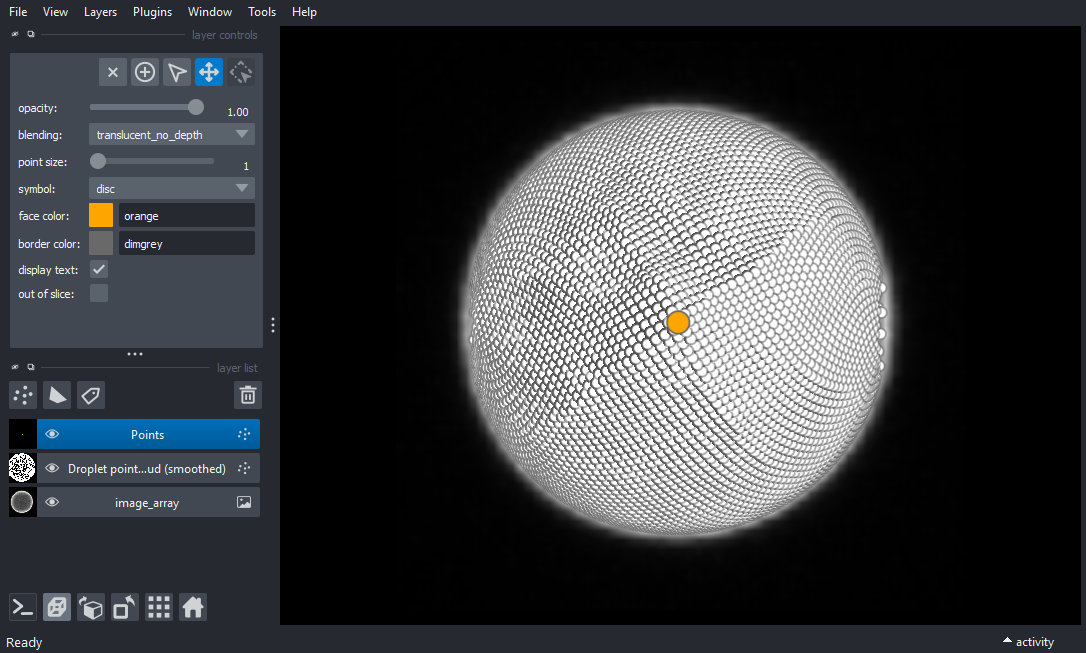

In [10]:
viewer.add_points(center_of_mass, size=1, blending='translucent_no_depth', face_color='orange')
napari.utils.nbscreenshot(viewer)

## Quantify errors: Curvature

What's a better estimate for the error is the *curvature* of the object. For a spherical object of radius *R*, the curvature at any point of the surface is given by 

$$
H = \frac{1}{R}
$$

In [22]:
# TODO: Replace by LebedevExpander later - will make execution of notebook much faster
measurements_results = measurements.comprehensive_analysis(
    points_reconstructed,
    max_degree=20,
    n_quadrature_points=5810,
    gamma=1.0,
)

Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity


In [12]:
viewer.add_layer(Layer.create(*measurements_results[4]))

<Points layer 'Result of lebedev quadrature (droplet)' at 0x2893bc49040>

In [23]:
mean_curvature = measurements_results[4][1]['features']['mean_curvature']
mean_curvature_reference = 1/ radius_mean

relative_error = np.abs(mean_curvature - mean_curvature_reference) / mean_curvature_reference

Text(0.05, 0.95, 'Average rel. error: 0.038\nStd. dev. rel. error: 0.027')

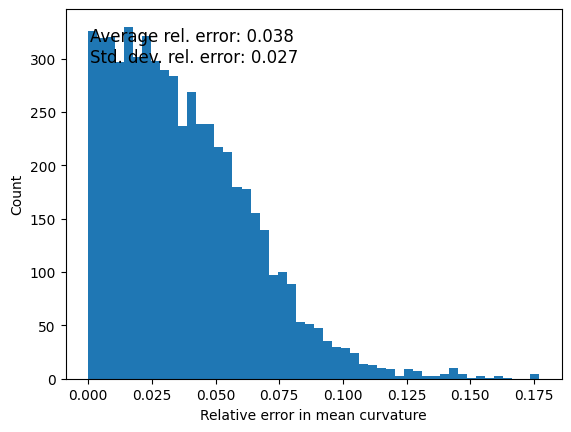

In [24]:
fig, ax = plt.subplots()
_ = ax.hist(relative_error, bins=50, density=False)

ax.set_xlabel('Relative error in mean curvature')
ax.set_ylabel('Count')
ax.text(0.05, 0.95, f'Average rel. error: {np.mean(relative_error):.3f}\n'
        f'Std. dev. rel. error: {np.std(relative_error):.3f}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

## Spherical harmonics error

Lastly, let's try to check what error the spherical harmonics expansion introduces. For this, we'll create an ideal shere, expand it using spherical harmonics, and then compare the curvature of the ideal sphere to the one we get from the spherical harmonics expansion.

In [25]:
radius = 10
sphere = vedo.IcoSphere(r=radius).subdivide(2)

expander = approximation.SphericalHarmonicsExpander(max_degree=10)
fitted_points = expander.fit_expand(sphere.vertices)


print(f'Number of points: {sphere.vertices.shape[0]}')

Number of points: 40962


Text(0.05, 0.95, 'Average rel. error: 0.001\nStd. dev. rel. error: 0.000')

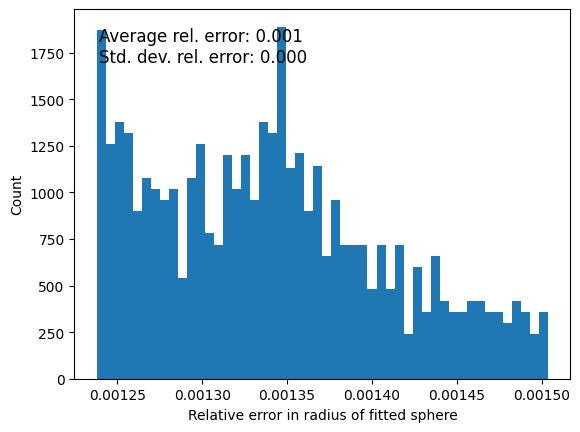

In [26]:
radii = np.linalg.norm(fitted_points, axis=1)
relative_error = np.abs(radii - radius) / radius

fig, ax = plt.subplots()
_ = ax.hist(relative_error, bins=50, density=False)

ax.set_xlabel('Relative error in radius of fitted sphere')
ax.set_ylabel('Count')
ax.text(0.05, 0.95, f'Average rel. error: {np.mean(relative_error):.3f}\n'
        f'Std. dev. rel. error: {np.std(relative_error):.3f}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

Again, we can also calculate mean curvature here and compare with the ideal curvature of the sphere;

In [27]:
# TODO: Replace by LebedevExpander later - will make execution of notebook much faster
measurements_results = measurements.comprehensive_analysis(
    sphere.vertices,
    max_degree=20,
    n_quadrature_points=5810,
    gamma=1.0,
)

Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity


In [28]:
mean_curvature = measurements_results[4][1]['features']['mean_curvature']
mean_curvature_reference = 1/ radius

relative_error = np.abs(mean_curvature - mean_curvature_reference) / mean_curvature_reference

Text(0.05, 0.95, 'Average rel. error: 0.005\nStd. dev. rel. error: 0.003')

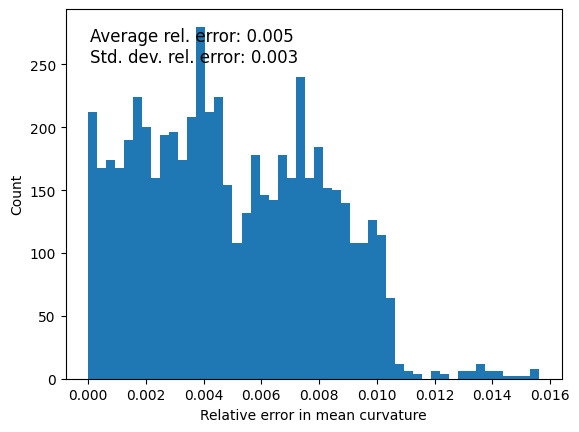

In [29]:
fig, ax = plt.subplots()
_ = ax.hist(relative_error, bins=50, density=False)

ax.set_xlabel('Relative error in mean curvature')
ax.set_ylabel('Count')
ax.text(0.05, 0.95, f'Average rel. error: {np.mean(relative_error):.3f}\n'
        f'Std. dev. rel. error: {np.std(relative_error):.3f}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top')